# ⚡ MOSFET 101

No introduction to analog IC design would be complete without a whistlestop tour of the basics of MOSFETs.

🎥 Video Insight:

<iframe width="560" height="315" src="https://www.youtube.com/embed/xeEQdo5MOGo?si=hZO2j8_oS0RD1krW" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

<iframe width="560" height="315" src="https://www.youtube.com/embed/pwrrcRuxjlQ?si=sWzgzv6njVdmNq2r" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

📝 Large-signal MOSFET behavior is summarized in the table below:

| Condition/Parameter          | Equation or Description                                                                 | Helpful intuition |
|------------------------------|----------------------------------------------------------------------------------------|-------------------|
| **MOSFET in Triode**         |                                                                                        |                   |
| Drain Current ($I_D$)        | $I_D = \frac{W}{L} \mu C_{ox} \left( V_{GS} - V_{th} \right) V_{DS}$ | Current is linear in $W/L$, $V_{eff}$ and $V_{DS}$ - very linear! |
| **MOSFET in Saturation**     |                                                                                        |                   |
| Drain Current ($I_D$)        | $I_D = \frac{1}{2} \frac{W}{L} \mu C_{ox} \left( V_{GS} - V_{th} \right)^2$           | In saturation, the current is only effected by $V_{eff}$ |
| **Channel Length Modulation**|                                                                                        |                   |
| Drain Current ($I_D$)        | $I_D = \frac{1}{2} \frac{W}{L} \mu C_{ox} \left( V_{GS} - V_{th} \right)^2 (1 + \lambda V_{DS})$ | In reality, there is a slight linear dependence on drain-source voltage in saturation. |
| **The Body Effect**          |                                                                                        |                   |
| Body Effect Parameter ($\gamma$) | $\gamma = \frac{\sqrt{2q \epsilon_{Si} N_{sub}}}{C_{ox}}$                           | Represents the influence of the substrate on the threshold voltage. |
| Threshold Voltage ($V_{th}$) | $V_{th} = V_{th0} + \gamma \left( \sqrt{2\phi_f + V_{SB}} - \sqrt{2\phi_f} \right)$   | $V_{th}$ is determined with $V_{SB}$ representing the source-to-body voltage. |

Where:
- $W$ and $L$ are the width and length of the MOSFET, respectively.
- $\mu$ is the carrier mobility.
- $C_{ox}$ is the oxide capacitance per unit area.
- $V_{GS}$ is the gate-source voltage.
- $V_{DS}$ is the drain-source voltage.
- $V_{th0}$ is the threshold voltage without the body effect.
- $\gamma$ is the body effect parameter.
- $2\phi_f$ is twice the Fermi potential.
- $V_{SB}$ is the source-body voltage.
- $\lambda$ is the channel length modulation parameter.
- $N_{sub}$ is the substrate doping concentration.
- $\epsilon_{Si}$ is the permittivity of silicon.
- $q$ is the electron charge.

Note: These equations are basic and idealized. In real-world applications, more detailed and complex models might be needed to accurately describe the behavior of MOSFETs.

💡 To experiment with, we'll first cover the large-signal behavior of a standard 3.3V NMOS from the GF180 MCU PDK:

##### 🧠 Exercises

1. See if you can identify the triode, saturation and short-channel regions of MOSFET operation
2. Change the `w` and `l` parameters of the device, do you get the changes you'd expect?

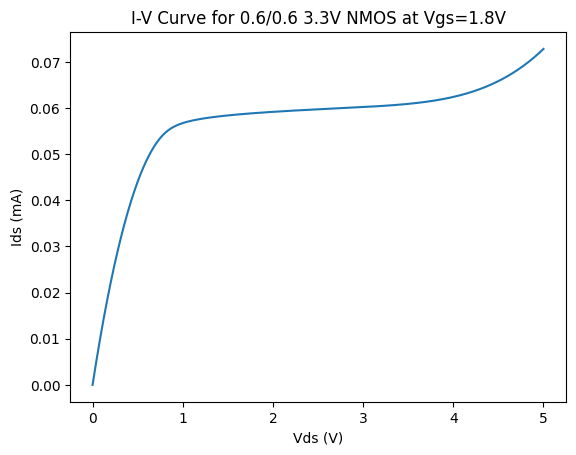

In [10]:
# Import the hdl21 library
import hdl21 as h
from hdl21.prefix import u
import vlsirtools.spice as vsp

# Import the SKY130 PDK
from sitepdks import *
import gf180_hdl21 as g
from gf180_hdl21 import primitives as p

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Don't touch any of this!
def get_sim(device : h.Module,vgs=1.8) -> h.sim.Sim:

    @h.sim.sim
    class DeviceSim:

        @h.module
        class Tb:

            # Set up our ports
            VSS = h.Port()
            VDD = h.Signal()
            
            # Define our voltages
            vdd = h.DcVoltageSource(dc=vgs)(p=VDD, n=VSS)
            sweep = h.PulseVoltageSource(delay=0,
                                         v1=0,
                                         v2=5,
                                         period=1,
                                         rise=1,
                                         fall=1,
                                         width=1)(n=VSS)
            # Instantiate our device
            DUT = device(d=sweep.p, g=VDD, s=VSS, b=VSS)

        tran = h.sim.Tran(tstop=1,tstep=0.001)
        inc1 = g.install.include_design()
        inc2 = g.install.include_mos(h.pdk.CmosCorner.TT)

    return DeviceSim

opts = vsp.SimOptions(
            simulator=vsp.SupportedSimulators.NGSPICE,
            fmt=vsp.ResultFormat.SIM_DATA,
            rundir="./scratch",
        )

import numpy as np
import matplotlib.pyplot as plt

# Modify vgs, W/L and simulate!
vgs=1.8
w, l = 0.6 * u, 0.6 * u
sim = get_sim(device=p.NFET_3p3V(w=w, l=l),vgs=vgs)
rvs = sim.run(opts=opts)

results = rvs[vsp.sim_data.AnalysisType.TRAN]

# Plot the results
x = results.data['v(xtop.sweep_p)']
y = -results.data['i(v.xtop.vsweep)']*1000

plt.xlabel('Vds (V)')
plt.ylabel('Ids (mA)')
plt.title(f'I-V Curve for {w.number}/{l.number} 3.3V NMOS at Vgs={vgs}V')

plt.plot(x,y)

### Small-Signal Models

MOSFETs are complicated non-linear devices, and often-times, we only require a small signal approximation of their behavior is tease out the intuitive properties that we need to think about design. Small-signal models are designed to investigate small changes around a bias voltage.

📝 The attributes of small-signal models are summarized in the table below :

| Model                        | Description                                                                                           | Purpose                                                                                     |
|------------------------------|-------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------|
| **Low-Frequency Hybrid-π Model** | Represents a MOSFET or BJT using a combination of resistors, capacitors, and controlled current sources. | Used to analyze and design amplifiers and other circuits at low frequencies where parasitic capacitances are not significant. |
| **T Model**                  | Simplified version of the hybrid-pi model, often used for BJTs. It replaces the controlled current source with a resistor. | Provides a more intuitive understanding of transistor operation and is useful for hand calculations. |
| **High-Frequency Hybrid-π Model** | Extends the low-frequency hybrid-pi model by including parasitic capacitances and other high-frequency effects. | Used for analyzing and designing circuits that operate at high frequencies where parasitic effects become significant. |

Essential small signal parameters are a repeated in a table below:

| Small-Signal Parameter | Description |
| ---------------------- | ----------- |
| $g_m = \dfrac{\partial I_D}{\partial V_{GS}}$ | **Transconductance**: Measures the sensitivity of the drain current ($I_D$) to changes in the gate-source voltage ($V_{GS}$). It indicates how effectively the gate controls the current flow between the drain and source. |
| $g_s = \dfrac{\partial I_D}{\partial V_{SB}}$ | **Substrate (or body) transconductance**: Represents the sensitivity of the drain current ($I_D$) to changes in the source-body voltage ($V_{SB}$). It's less commonly used compared to $g_m$. |
| $r_{ds} = \dfrac{\partial V_{DS}}{\partial I_D}$ | **Drain-source resistance**: This is the small-signal resistance between the drain and source terminals when the MOSFET is in the active (or saturation) region. It's essentially the inverse of the slope of the $I_D$ vs. $V_{DS}$ curve in the saturation region. |
| $C_{dg}$ | **Drain-gate capacitance**: Represents the capacitance between the drain and gate terminals. It's due to the overlap of the gate and drain regions and the channel charge. |
| $C_{gs}$ | **Gate-source capacitance**: Represents the capacitance between the gate and source terminals. It's primarily due to the overlap of the gate and source regions and the accumulation of charge in the channel beneath the gate. |
| $C_{db}$ | **Drain-body capacitance**: This is the capacitance between the drain and the body (or substrate) of the MOSFET. It's associated with the reverse-biased drain-body junction. |
| $C_{sb}$ | **Source-body capacitance**: Represents the capacitance between the source and the body (or substrate) of the MOSFET. It's associated with the reverse-biased source-body junction. |

We repeat the circuit diagrams for these models:

##### Low Frequency Hybrid-$\pi$ Model

![Low Frequency Hybrid Pi](img/lowfreq_hybridpi.png)

##### T Model

![T Model](img/tmodel.png)

##### High Frequency Hybrid-$\pi$ Model

![High Frequency Hybrid Pi](img/highfreq_hybridpi.png)

💡 In the next few simulations, we investigate the small-signal approximation of MOSFETs, how well and under what conditions they can emulate fully-simulated devices:

##### 🧠 Exercises

1. Tinker with the small-signal models.
2. Given a certain value of $I_D$, $V_{GS}$, $\lambda$, and $V_{BS}$, calculate the transconductance ($g_m$) and output resistance ($r_{ds}$) for both the π-model and T-model in low and high frequencies.
3. Explain the differences between the π-model and T-model. Under what circumstances would one be preferred over the other?

In [ ]:
@h.sim.sim
class LowFreqPiModelSim:

    @h.module
    class Tb:

        # Set up our ports
        VSS = h.Port()
        VDD = h.Signal()
        VGG = h.Signal()
        VBB = h.Signal()

        # Define our voltages
        vgs = h.DcVoltageSource(dc=1.8)(p=VGG, n=VSS)
        vsb = h.DcVoltageSource(dc=1.8)(p=VSS, n=VBB)

        # Instantiate our device
        Rds = h.IdealResistor()(p=VDD, n=VSS)
        gmvgs = h.VoltageControlledCurrentSource(cp=VBB, cn=VSS, p=VDD, n=VSS)
        gsvsb = h.VoltageControlledCurrentSource(cp=VGG, cn=VSS, p=VSS, n=VDD)

@h.sim.sim
class LowFreqTModelSim:

    @h.module
    class Tb:

        # Set up our ports
        VSS = h.Port()
        VDD = h.Signal()
        VGG = h.Signal()

        # Define our voltages
        vgs = h.DcVoltageSource(dc=1.8)(p=VGG, n=VSS)

        # Instantiate our device
        Rds = h.IdealResistor()(p=VDD, n=VSS)
        rs = h.IdealResistor()(p=VGG, n=VSS)
        gmvgs = h.VoltageControlledCurrentSource(cp=VGG, cn=VSS, p=VDD, n=VGG)

@h.sim.sim
class HighFreqPIModelSim:

        @h.module
        class Tb:
    
            VSS = h.Port()
            VDD = h.Signal()
            VGG = h.Signal()
            VBB = h.Signal()

            # Define our voltages
            vgs = h.DcVoltageSource(dc=1.8)(p=VGG, n=VSS)
            vsb = h.DcVoltageSource(dc=1.8)(p=VSS, n=VBB)

            # Instantiate our device
            Rds = h.IdealResistor()(p=VDD, n=VSS)
            gmvgs = h.VoltageControlledCurrentSource(cp=VBB, cn=VSS, p=VDD, n=VSS)
            gsvsb = h.VoltageControlledCurrentSource(cp=VGG, cn=VSS, p=VSS, n=VDD)

            # Add parasitics
            cgs = h.IdealCapacitor()(p=VGG, n=VSS)
            cgd = h.IdealCapacitor()(p=VGG, n=VDD)
            csb = h.IdealCapacitor()(p=VSS, n=VBB)
            cdb = h.IdealCapacitor()(p=VDD, n=VBB)